In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Creating a PyTorch Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from Data import train_loader, test_loader



num_epochs = 10000

learning_rate = 10**(-3)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(N_nod, N_nod)
        )

    def forward(self, x):
        logits = self.layers_stack(x)
        return logits
    
    



    
    
model = NeuralNetwork()


criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for features, targets in dataloader:
        # Compute prediction and loss
        pred = model(features)
        loss = criterion(pred, targets)

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss = 0

    with torch.no_grad():
        for features, targets in dataloader:
            # Compute prediction and loss
            pred = model(features)
            loss = criterion(pred, targets)

            test_loss += loss.item()


    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")

    return test_loss








loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    test_loss = test_loop(test_loader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")


Epochs=[i for i in range(num_epochs)]
plt.figure()
plt.title("learning_rate="+str(learning_rate),fontsize=17)
plt.plot(Epochs,loss_history["train"])
plt.plot(Epochs,loss_history["test"])
plt.legend(["train","test"])
plt.ylabel("MSE",fontsize=17)
plt.xlabel("epoch",fontsize=17)
plt.grid(True)
plt.show()

torch.save(model.state_dict(), "model_weights1.pth")

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

m=torch.nn.Linear(10,10,bias=False)
W=m.weight
print(W)
det=torch.det(W)
print(det)

class LinearNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            m
        )

    def forward(self, x):
        x_out = self.layers_stack(x)
        return x_out
    

def criterion(x_out):
    return mean(p(x_out)-fullS(x_out))

#p=det*exp(-(Wx)TWx)
#S=sum model.S(x[i-1],x[i])


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [04:23<00:00,  2.27it/s]


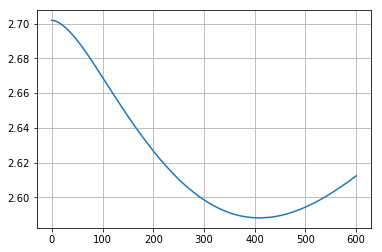

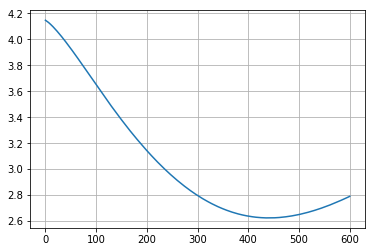

In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from constants import N_nod,a, N_traj
from andist import A, C
from tqdm import tqdm
import random
from Data import train_loader


def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)



A=torch.tensor(A).float()
C=torch.tensor(C).float()


class Action(nn.Module):
    def __init__(self,A):
        super().__init__()
        self.A=A
    
    def forward(self,x):
        y=torch.matmul(self.A,x)
        return 1/2 * torch.dot(y,x) 

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, x, act, model):
        loss=0
        M=len(x)
        for i in range(M):
            loss+=act(x[i])
        loss=loss/M
        det=torch.det(model.weight)
        Log=torch.log(torch.abs(det))
        loss=loss-Log
        return loss

def w_C(model):
    wt=model.weight
    w=torch.t(model.weight)
    return torch.linalg.matrix_norm(w-C)
def A_I(model):
    wt=model.weight
    w=torch.t(model.weight)
    A_D=torch.matmul(wt,torch.matmul(A,w))
    I=torch.eye(N_nod)
    return torch.linalg.matrix_norm(A_D-I)    
 
set_random_seed(42)    
model=nn.Linear(N_nod,N_nod,bias=False)
#print(model.weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

act=Action(A)
loss_fn = CustomLoss()
num_epochs=600
metric1=[w_C(model)]
metric2=[A_I(model)]


for epoch in tqdm(range(num_epochs)):
    for x in train_loader:
        # Forward pass
        outputs = model(x)
        loss = loss_fn(outputs,act,model)
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    metric1.append(w_C(model))
    metric2.append(A_I(model))


fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric1)
plt.grid(True)
plt.show()

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric2)
plt.grid(True)
plt.show()



In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from constants import N_nod,a, N_traj
from andist import A, C
from tqdm import tqdm
import random
from Data import train_loader
from LOSS import KL_osc


def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

A=torch.tensor(A).float()
C=torch.tensor(C).float()




def w_C(model):
    wt=model.weight
    w=torch.t(model.weight)
    return torch.linalg.matrix_norm(w-C)
def A_I(model):
    wt=model.weight
    w=torch.t(model.weight)
    A_D=torch.matmul(wt,torch.matmul(A,w))
    I=torch.eye(N_nod)
    return torch.linalg.matrix_norm(A_D-I)    
 
    
model=nn.Linear(N_nod,N_nod,bias=False)
#print(model.weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = KL_osc
num_epochs=30
metric1=[w_C(model)]
metric2=[A_I(model)]


for epoch in tqdm(range(num_epochs)):
    for x in train_loader:
        # Forward pass
        outputs = model(x)
        det=torch.det(model.weight)
        log_prob=torch.log(torch.abs(det))
        loss = loss_fn(outputs,log_prob)
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    metric1.append(w_C(model))
    metric2.append(A_I(model))

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric1)
plt.grid(True)
plt.show()

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric2)
plt.grid(True)
plt.show()


  3%|██▊                                                                                | 1/30 [00:46<22:39, 46.87s/it]


KeyboardInterrupt: 

In [2]:
print(torch.linalg.matrix_norm(A_D-I))

tensor(4.1289, grad_fn=<CopyBackwards>)


In [4]:
import torch
x=torch.empty((5,5)).normal_(mean=0,std=1)
print(x)

tensor([[ 0.6269,  0.5066, -2.1181, -1.3762, -0.1641],
        [-1.4673, -0.2143,  1.5959, -0.1959,  0.8711],
        [-0.8142,  1.5881,  0.5889, -0.2056,  0.6594],
        [-0.9880, -3.1961,  1.3557, -0.4746,  0.1106],
        [ 1.1299,  0.2695, -0.1797,  0.2063,  0.2828]])


In [31]:
import torch
from torch import nn

m=nn.Linear(3,3,bias=False)
W=m.weight
print(W)
det=torch.det(W)
print(det)
z = torch.randn(3, 3)
print(x)
y=m(x)
print(torch.dot(y,x))



Parameter containing:
tensor([[-0.2923,  0.0250, -0.2512],
        [ 0.0650,  0.3000, -0.3059],
        [-0.3540,  0.3110, -0.2956]], requires_grad=True)
tensor(-0.0305, grad_fn=<DetLuBasedHelperBackward0>)
tensor([[1.1000, 2.2000, 3.3000],
        [1.4000, 2.5000, 3.6000],
        [1.3000, 2.3000, 3.3000]])


TypeError: dot() got an unexpected keyword argument 'axis'

In [17]:
m = nn.Linear(3, 3)
input = torch.randn(10, 3)
print(input)
output = m(input)
print(output.size())

tensor([[ 0.2469,  0.4728, -0.3868],
        [ 0.2693, -0.8485, -1.0047],
        [ 0.3464,  0.0428, -0.3292],
        [-0.5103, -0.6700, -0.9507],
        [-0.8863,  0.2683,  1.6451],
        [-1.0197, -0.2413,  0.5959],
        [ 0.6121, -2.4313, -0.5840],
        [-0.5501,  0.4592, -0.0392],
        [-2.0275,  0.5105, -1.3787],
        [-1.5137,  0.2372,  0.4769]])
torch.Size([10, 3])


In [2]:
from Data import train_loader
batch = next(iter(train_loader))
print(batch)

tensor([[ 2.0633,  0.1426,  1.7276,  ..., -1.2586, -0.3507, -1.1229],
        [ 0.8302, -0.8798,  0.0640,  ...,  0.5792,  0.1199, -0.6184],
        [-0.7187,  0.7230,  0.5051,  ...,  2.2746, -0.3314, -2.0507],
        ...,
        [ 0.2208,  1.3205,  1.2693,  ..., -0.0271,  0.6390, -1.4495],
        [ 1.1972,  0.7524,  0.3565,  ..., -1.8288,  0.8331, -0.5247],
        [-0.7469,  2.0256,  0.3498,  ...,  1.4380,  0.1296, -0.0884]])


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 218.37it/s]


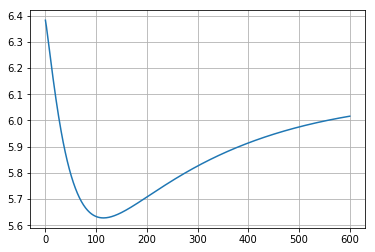

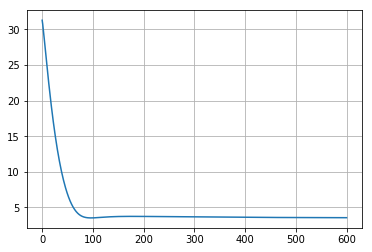

'   \nwt=model.weight\nw=torch.t(model.weight)\n\nprint(torch.linalg.matrix_norm(w-C))\nA_D=torch.matmul(wt,torch.matmul(A,w))\nI=torch.eye(N_nod)\nprint(torch.linalg.matrix_norm(A_D-I))\n'

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from constants import N_nod,a, N_traj
from andist import A, C
from tqdm import tqdm
import random
from torch.nn.utils.parametrizations import orthogonal



def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

A=torch.tensor(A).float()
C=torch.tensor(C).float()


class Action(nn.Module):
    def __init__(self,A):
        super().__init__()
        self.A=A
    
    def forward(self,x):
        y=torch.matmul(self.A,x)
        return 1/2 * torch.dot(y,x) 


class Cheatloss(nn.Module):
    def __init__(self):
        super(Cheatloss, self).__init__()

    def forward(self,act, model):
        a=act.A
        w=torch.t(model.weight)
        wt=torch.t(w)
        A_D=torch.matmul(wt,torch.matmul(a,w))
        det=torch.det(w)
        loss=torch.trace(A_D)-torch.log(torch.abs(det))
        return loss

def w_C(model):
    wt=model.weight
    w=torch.t(model.weight)
    return torch.linalg.matrix_norm(w-C)
def A_I(model):
    wt=model.weight
    w=torch.t(model.weight)
    A_D=torch.matmul(wt,torch.matmul(A,w))
    I=torch.eye(N_nod)
    return torch.linalg.matrix_norm(A_D-I)
    
#model=orthogonal(nn.Linear(N_nod,N_nod,bias=False))
model=nn.Linear(N_nod,N_nod,bias=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

act=Action(A)
loss_fn = Cheatloss()
num_epochs=600
metric1=[w_C(model)]
metric2=[A_I(model)]


for epoch in tqdm(range(num_epochs)):
        # Forward pass
    loss = loss_fn(act,model)
    
        # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    metric1.append(w_C(model))
    metric2.append(A_I(model))

    
fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric1)
plt.grid(True)
plt.show()

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric2)
plt.grid(True)
plt.show()
    
"""   
wt=model.weight
w=torch.t(model.weight)

print(torch.linalg.matrix_norm(w-C))
A_D=torch.matmul(wt,torch.matmul(A,w))
I=torch.eye(N_nod)
print(torch.linalg.matrix_norm(A_D-I))
"""

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.49it/s]


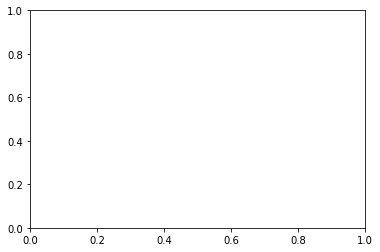

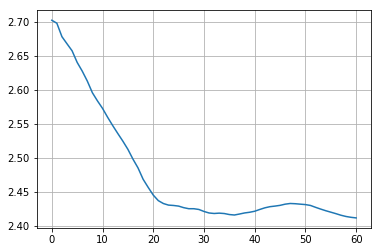

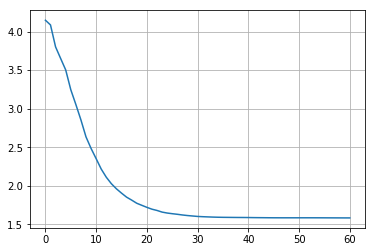

'\n#print(hist)\nprint(torch.linalg.matrix_norm(w-C))\nA_D=torch.matmul(wt,torch.matmul(A,w))\nI=torch.eye(N_nod)\nprint(torch.linalg.matrix_norm(A_D-I))\nfig=plt.figure()\nplt.plot(list(range(num_epochs)),hist[::20])\nplt.show()\n'

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from constants import N_nod,a, N_traj
from andist import A, C
from tqdm import tqdm
import random
from torch.nn.utils.parametrizations import orthogonal



def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

A=torch.tensor(A).float()
C=torch.tensor(C).float()


class Action(nn.Module):
    def __init__(self,A):
        super().__init__()
        self.A=A
    
    def forward(self,x):
        y=torch.matmul(self.A,x)
        return 1/2 * torch.dot(y,x) 


class Cheatloss(nn.Module):
    def __init__(self):
        super(Cheatloss, self).__init__()

    def forward(self,act, model):
        a=act.A
        w=torch.t(model.weight)
        wt=torch.t(w)
        A_D=torch.matmul(wt,torch.matmul(a,w))
        det=torch.det(w)
        loss=torch.trace(A_D)-torch.log(torch.abs(det))
        return loss    
    
    
def w_C(model):
    wt=model.weight
    w=torch.t(model.weight)
    return torch.linalg.matrix_norm(w-C)
def A_I(model):
    wt=model.weight
    w=torch.t(model.weight)
    A_D=torch.matmul(wt,torch.matmul(A,w))
    I=torch.eye(N_nod)
    return torch.linalg.matrix_norm(A_D-I)        
    
#model=orthogonal(nn.Linear(N_nod,N_nod,bias=False))
model=nn.Linear(N_nod,N_nod,bias=False)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)

act=Action(A)
loss_fn = Cheatloss()
num_epochs=60
metric1=[w_C(model)]
metric2=[A_I(model)]

def closure():
    loss = loss_fn(act,model)
    #hist.append(loss)
    optimizer.zero_grad()
    loss.backward()
    #print(epoch,loss,"\n")
    metric1.append(w_C(model))
    metric2.append(A_I(model))
    return loss
    



for epoch in tqdm(range(num_epochs)):
    optimizer.step(closure)
    

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric1[::20])
plt.grid(True)
plt.show()

fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric2[::20])
plt.grid(True)
plt.show()
    
"""
#print(hist)
print(torch.linalg.matrix_norm(w-C))
A_D=torch.matmul(wt,torch.matmul(A,w))
I=torch.eye(N_nod)
print(torch.linalg.matrix_norm(A_D-I))
fig=plt.figure()
plt.plot(list(range(num_epochs)),hist[::20])
plt.show()
"""